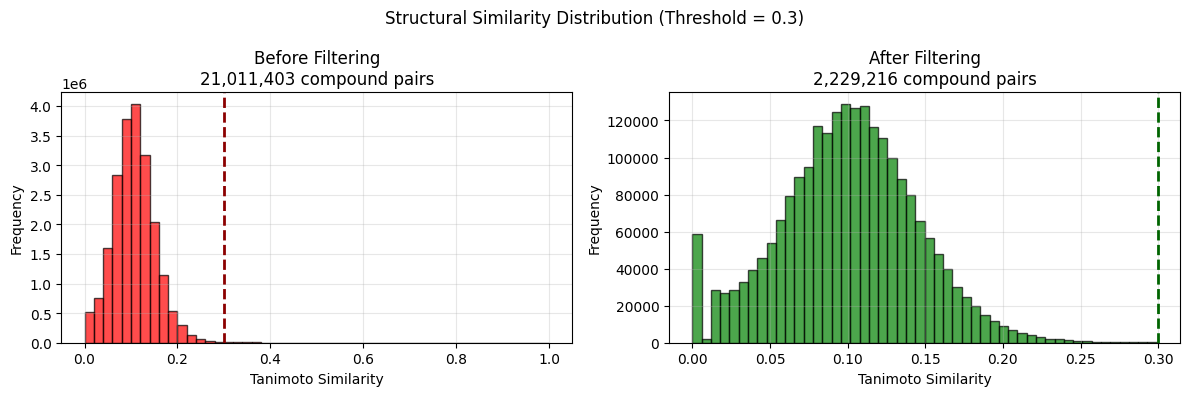

STRUCTURAL SIMILARITY ANALYSIS RESULTS
Compounds before filtering: 6483
Compounds after filtering:  2112
Compounds removed:          4371
Retention rate:             32.6%

Compound pairs:
  Before: 21,011,403 pairs
  After:  2,229,216 pairs

Similarity statistics:
  Mean similarity before: 0.107
  Mean similarity after:  0.101
  Max similarity before:  1.000
  Max similarity after:   0.299
  Pairs ≥ 0.3:     50,335 → 0


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

def calculate_fingerprint(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

def calculate_tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def calculate_similarity_matrix(mols):
    n_mols = len(mols)
    fingerprints = [calculate_fingerprint(mol) for mol in mols]
    
    similarity_matrix = np.zeros((n_mols, n_mols))
    
    for i in range(n_mols):
        for j in range(i, n_mols):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                sim = calculate_tanimoto_similarity(fingerprints[i], fingerprints[j])
                similarity_matrix[i, j] = sim
                similarity_matrix[j, i] = sim
    
    return similarity_matrix, fingerprints

def get_similarity_distribution(similarity_matrix):
    n = similarity_matrix.shape[0]
    similarities = []
    
    for i in range(n):
        for j in range(i + 1, n):
            similarities.append(similarity_matrix[i, j])
    
    return np.array(similarities)

def filter_similar_compounds(mols, fingerprints, threshold=0.3):
    n = len(mols)
    to_keep = [True] * n
    
    for i in range(n):
        if not to_keep[i]:
            continue
        
        for j in range(i + 1, n):
            if not to_keep[j]:
                continue
            
            sim = calculate_tanimoto_similarity(fingerprints[i], fingerprints[j])
            if sim >= threshold:
                to_keep[j] = False
    
    return [mols[i] for i in range(n) if to_keep[i]]

def load_data_from_csv(csv_path):
    try:
        df = pd.read_csv(csv_path)
    except:
        return None
    
    smiles_col = None
    for col in df.columns:
        if 'smile' in col.lower():
            smiles_col = col
            break
    
    if not smiles_col and 'SMILES' in df.columns:
        smiles_col = 'SMILES'
    
    if not smiles_col:
        return None
    
    df_clean = df.dropna(subset=[smiles_col])
    df_clean = df_clean.drop_duplicates(subset=[smiles_col])
    
    mols = []
    for smiles in df_clean[smiles_col]:
        mol = Chem.MolFromSmiles(str(smiles).strip())
        if mol is not None:
            mols.append(mol)
    
    return mols

def analyze_structural_similarity(csv_path, threshold=0.3):
    # Load data
    mols = load_data_from_csv(csv_path)
    if not mols:
        print("Error: Could not load data")
        return
    
    before_count = len(mols)
    
    # Calculate similarities BEFORE filtering
    before_matrix, fingerprints = calculate_similarity_matrix(mols)
    before_similarities = get_similarity_distribution(before_matrix)
    before_pairs = len(before_similarities)
    
    # Filter similar compounds
    filtered_mols = filter_similar_compounds(mols, fingerprints, threshold)
    after_count = len(filtered_mols)
    
    # Calculate similarities AFTER filtering
    if after_count > 1:
        after_matrix, _ = calculate_similarity_matrix(filtered_mols)
        after_similarities = get_similarity_distribution(after_matrix)
        after_pairs = len(after_similarities)
    else:
        after_similarities = np.array([])
        after_pairs = 0
    
    # Plot histogram
    if len(after_similarities) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Calculate number of pairs: n*(n-1)/2
        before_pairs = before_count * (before_count - 1) // 2
        after_pairs = after_count * (after_count - 1) // 2
        
        ax1.hist(before_similarities, bins=50, alpha=0.7, color='red', edgecolor='black')
        ax1.axvline(x=threshold, color='darkred', linestyle='--', linewidth=2)
        ax1.set_title(f'Before Filtering\n{before_pairs:,} compound pairs')
        ax1.set_xlabel('Tanimoto Similarity')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)
        
        ax2.hist(after_similarities, bins=50, alpha=0.7, color='green', edgecolor='black')
        ax2.axvline(x=threshold, color='darkgreen', linestyle='--', linewidth=2)
        ax2.set_title(f'After Filtering\n{after_pairs:,} compound pairs')
        ax2.set_xlabel('Tanimoto Similarity')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle(f'Structural Similarity Distribution (Threshold = {threshold})')
        plt.tight_layout()
        plt.show()
    
    # Final summary
    print("=" * 50)
    print("STRUCTURAL SIMILARITY ANALYSIS RESULTS")
    print("=" * 50)
    print(f"Compounds before filtering: {before_count}")
    print(f"Compounds after filtering:  {after_count}")
    print(f"Compounds removed:          {before_count - after_count}")
    print(f"Retention rate:             {(after_count/before_count)*100:.1f}%")
    
    print(f"\nCompound pairs:")
    print(f"  Before: {before_pairs:,} pairs")
    print(f"  After:  {after_pairs:,} pairs")
    
    if len(before_similarities) > 0 and len(after_similarities) > 0:
        print(f"\nSimilarity statistics:")
        print(f"  Mean similarity before: {np.mean(before_similarities):.3f}")
        print(f"  Mean similarity after:  {np.mean(after_similarities):.3f}")
        print(f"  Max similarity before:  {np.max(before_similarities):.3f}")
        print(f"  Max similarity after:   {np.max(after_similarities):.3f}")
        print(f"  Pairs ≥ {threshold}:     {np.sum(before_similarities >= threshold):,} → {np.sum(after_similarities >= threshold):,}")

# Run the analysis
CSV_FILE_PATH = "../Data/drugs_with_sider_labels.csv"  # Update this path
THRESHOLD = 0.3

analyze_structural_similarity(CSV_FILE_PATH, THRESHOLD)